# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
import numpy as np
import pandas as pd
import os
import csv

### Change directory

In [0]:
import os
os.chdir('/Users/siddharthmehta/Desktop/python-workspace/PGP AIML Labs/Internal Lab 9/images')

In [0]:
import sys
!{sys.executable} -m conda install rarfile

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - rarfile

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/osx-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




### Load the training data from train.csv file

In [0]:
data_train = pd.read_csv("train_labels.csv")

In [0]:
from rarfile import RarFile

### Print the shape of the train dataset

In [0]:
data_train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
paths = []
coords = np.zeros((data_train.shape[0], 4))
for index, row in data_train.iterrows():
    path = row['filename']
    coords[index, 0] = row['xmin'] * IMAGE_SIZE / row['width'] # Normalize bounding box by image size
    coords[index, 1] = row['ymin'] / row['height'] # Normalize bounding box by image size
    coords[index, 2] = (row['xmax'] - row['xmin']) * IMAGE_SIZE / row['width'] # Normalize bounding box by image size
    coords[index, 3] = (row['ymax'] - row['ymin']) * IMAGE_SIZE / row['height']
    paths.append(path)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
from keras.applications.mobilenet import preprocess_input
from PIL import Image

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [0]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
from keras.applications.mobilenet import MobileNet
from keras.layers import Conv2D
from keras.layers import Reshape
from keras import Model

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
import tensorflow as tf
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
from keras.utils import Sequence
from keras.backend import epsilon
from keras.applications.mobilenet import preprocess_input

In [0]:
model.compile(optimizer = 'Adam', loss = 'mse', metrics = [IoU]) 
model.fit(batch_images,gt,
            epochs = 30,batch_size = 32,
            verbose = 1)

Epoch 1/30
173/173 [==============================] - 6s 33ms/step - loss: 1690.7674 - IoU: 0.1881
Epoch 2/30
173/173 [==============================] - 2s 9ms/step - loss: 472.1623 - IoU: 0.5280
Epoch 3/30
173/173 [==============================] - 2s 9ms/step - loss: 538.0956 - IoU: 0.5636
Epoch 4/30
173/173 [==============================] - 2s 9ms/step - loss: 366.0782 - IoU: 0.5974
Epoch 5/30
173/173 [==============================] - 2s 9ms/step - loss: 258.2458 - IoU: 0.6024
Epoch 6/30
173/173 [==============================] - 2s 9ms/step - loss: 229.7011 - IoU: 0.6315
Epoch 7/30
173/173 [==============================] - 2s 9ms/step - loss: 179.1596 - IoU: 0.6751
Epoch 8/30
173/173 [==============================] - 2s 9ms/step - loss: 140.9503 - IoU: 0.7170
Epoch 9/30
173/173 [==============================] - 2s 9ms/step - loss: 130.9136 - IoU: 0.7306
Epoch 10/30
173/173 [==============================] - 2s 9ms/step - loss: 114.3568 - IoU: 0.7359
Epoch 11/30
173/173 [======

### Pick a test image from the given data

In [0]:
unscaled = cv2.imread('raccoon-1.jpg') # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

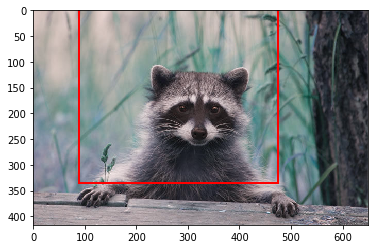

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [1]:
from google.colab import drive
from subprocess import check_output
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


#### Change your present working directory

In [0]:
import os
os.chdir('../content/gdrive/My Drive/Colab Notebooks/Internal Lab 9/')

In [6]:
check_output("pwd")

b'/content/gdrive/My Drive/Colab Notebooks/Internal Lab 9\n'

### Load your data file

In [0]:
data = pd.read_csv('daily-minimum-temperatures-in-me.csv', index_col = ['Date'])

#### Plot data

            Temperature
Date                   
1981-01-01         20.7
1981-01-02         17.9
1981-01-03         18.8
1981-01-04         14.6
1981-01-05         15.8


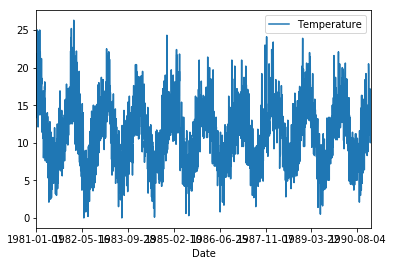

In [8]:
print(data.head())
data.plot()

#### Descibe your dataframe

In [9]:
data.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [10]:
data[data.isnull().any(axis=1)]

,Temperature
Date,


In [11]:
data[data.isna().any(axis=1)]

,Temperature
Date,


In [0]:
#No NaN/NULL Values Observed

#### Drop null values

In [0]:
data.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3cd275b70>]],
      dtype=object)

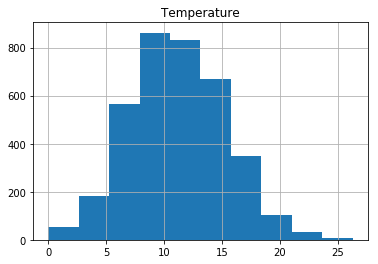

In [14]:
data.hist(bins=10)

#### Check the maximum and minimum values

In [15]:
# Scaled Data
print('Min', np.min(data))
print('Max', np.max(data))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler
data = data.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

#### Check the maximum and minimum values of scaled data

In [17]:
# Scaled Data
print('Min', np.min(data))
print('Max', np.max(scaled_data))

Min Temperature    0.0
dtype: float32
Max 1.0


#### Look into some of the scaled values

In [18]:
scaled_data

array([[0.7870723 ],
       [0.68060837],
       [0.71482889],
       ...,
       [0.513308  ],
       [0.59695818],
       [0.49429659]])

### Split data into Training and Testing

In [0]:
#Create the model
train_size = int(len(scaled_data) * 0.70)
test_size = len(scaled_data - train_size)
train, test = scaled_data[0:train_size, :], scaled_data[train_size: len(scaled_data), :]

#### Print train and test size

In [20]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [22]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers

In [0]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, 1, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summarize your model

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [36]:
model.fit(X_train, y_train, epochs=30, batch_size=batch_size, shuffle=True)

Epoch 1/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0129
Epoch 2/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0122
Epoch 3/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0114
Epoch 4/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0113
Epoch 5/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0112
Epoch 6/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0109
Epoch 7/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0105
Epoch 8/30
2553/2553 [==============================] - 11s 4ms/step - loss: 0.0105
Epoch 9/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0103
Epoch 10/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0104
Epoch 11/30
2553/2553 [==============================] - 10s 4ms/step - loss: 0.0102
Epoch 12/30
2553/2553 [==============================] - 11s 4ms/step - lo

## Make Predictions and Evaluate your model

In [37]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.62 RMSE
Test Score: 2.47 RMSE


## Plot the results

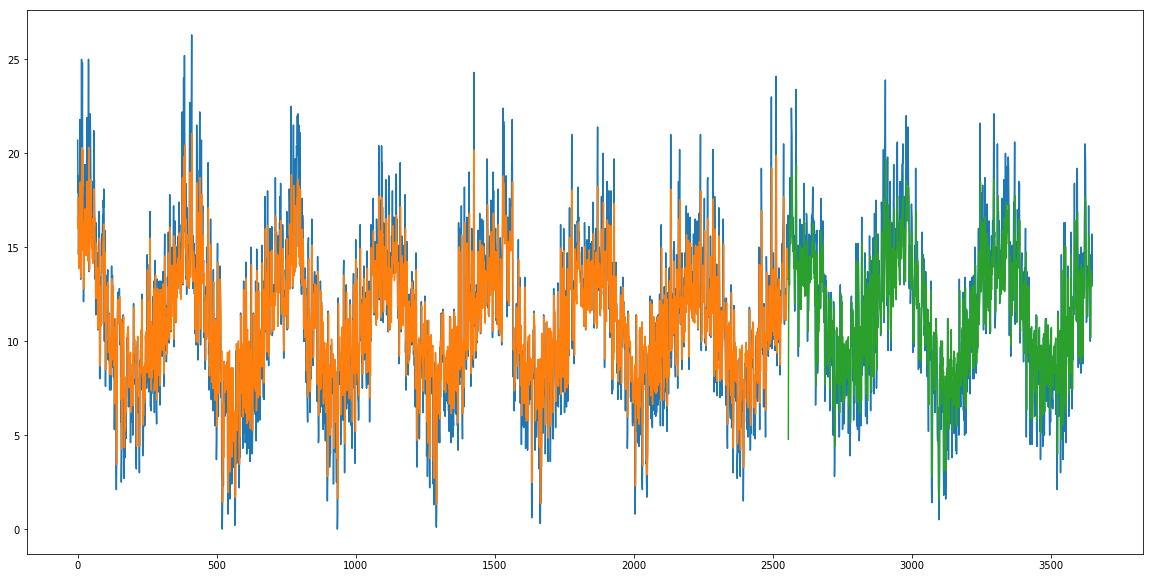

In [42]:
from matplotlib import pyplot as plt
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled_data)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()